Speed climbing in pictures
====


# 1. Presentation and learning objectives
This is my first data visualization project, using speed climbing World Cup statistics from the International Federation of Sport Climbing. 

The main goal was to get comfortable with the pandas and matplotlib libraries for data exploration and visualization. I made plots of all basic types (lines, bar charts, scatter...), incorporating interactivity in some examples (eg. to display world record holders).

 - File processing and raw text cleaning with `os` and `re`
 - Data wrangling and exploration with `pandas`
 - Data visualization with `matplotlib` and `seaborn`


_This project was inspired by the final assignment in the coursera "Applied data science with Python" course from the University of Michigan._

In [1]:
%matplotlib notebook

In [2]:
import os
import re
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# 2. Data cleaning
I used the results from all IFSC World Cup competitions since 2011 (when the first World Records were established). World Championships were excluded, as well as any competition whose results (for male and female competitors) were partially or fully missing from the [the IFSC website](https://www.ifsc-climbing.org/index.php). I might add other competitions later.

I manually copy/pasted 112 raw text files (one file per competition per gender since 2011) from the IFSC website's [results page](https://www.ifsc-climbing.org/index.php/world-competition/last-result), then organized the data into a pandas dataframe (saved as a .csv file). Columns were 'tidied' according to the guidelines in Hadley Wickham's [Tidy Data](http://vita.had.co.nz/papers/tidy-data.pdf) paper.

In [3]:
#----------Parse data----------#

def process_file(filename):
    with open("data/raw/" + filename, 'r') as f:
        content = f.read()
        content = re.sub(re.compile('[\n\t]+'), ',', content)
        content = re.sub(re.compile(',+'), ',', content)
        content = re.sub(re.compile(',(?=\d+,)'), '\n', content)
    with open("data/clean/" + filename, 'w') as f:
        f.write(content)

        
def make_dataframe(filename):
    df = pd.read_csv("data/clean/" + filename, header = None, names=['rank', 'first_name', 'last_name', 'nation', 'qualifications', 'final'], index_col=False)
    df[['year', 'gender', 'city', 'country']] = filename.split('-')
    return df

for filename in os.listdir("data/raw"):
    process_file(filename)

df = (pd.concat([make_dataframe(filename) for filename in os.listdir("data/clean")])).reset_index(drop=True)

In [4]:
#----------Tidy columns----------#

df['first_name'] += ' ' + df['last_name']
df = df.drop(['last_name'], axis=1).rename(columns={'first_name':'name'})

df = df.melt(id_vars=['year', 'country', 'city', 'gender', 'rank', 'name', 'nation'], var_name='round', value_name='time')
df['forfeit'] = df.loc[df['time'].str.replace('.', '').str.isnumeric() == False]['time']
df['time'] = df.loc[df['time'].str.replace('.', '').str.isnumeric() == True]['time']

In [5]:
#-------------Save-------------#

df.to_csv("data/data.csv", index=False)

# 3. Exploring the data
_NOTE: Throughout, women's performances are displayed in blue and men's in orange_

## Evolution of the world record throughout the years.
An overview of recent world record history is available [here](https://www.ifsc-climbing.org/index.php/world-competition/speed-world-record-overview).

Note: Times higher than 16 seconds (12 seconds for men) were ignored in mean computations as these correspond to slips/fumbles and are not representatives of overall ahtlete's performance.

**Observations.**
- The trends in both world records are reflected in the average time of the top 16 athletes in each competition; the season (and world)'s record seem to reflect a general trend rather than a fluke. 
- The women's curve presents a steeper downward trend than the men's; a possible explanation would be that women are still further from theoretical physical limitations than men.

In [6]:
df = pd.read_csv("data/data.csv", index_col=False)  # since 'rank' column is int, need index = False else duplicate index

In [7]:
class HiddenAnnotation:
    def __init__(self, annotation, pickradius=0.3):
        self.x, self.y = annotation.xy
        self.text = annotation
        self.pickradius = pickradius
        self.text.set_visible(False)

    def connect(self):
        self.cidmotion = self.text.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)

    def on_press(self, event):
        'on button press, store some data'
        if event.inaxes != self.text.axes: return
        if self.x - self.pickradius <= event.xdata <= self.x + self.pickradius and self.y - self.pickradius <= event.ydata <= self.y + self.pickradius:
            self.text.set_visible(True)
            self.text.figure.canvas.draw()
        else:
            self.text.set_visible(False)
            self.text.figure.canvas.draw()

    def disconnect(self):
        'disconnect all the stored connection ids'
        self.text.figure.canvas.mpl_disconnect(self.cidmotion)

<IPython.core.display.Javascript object>


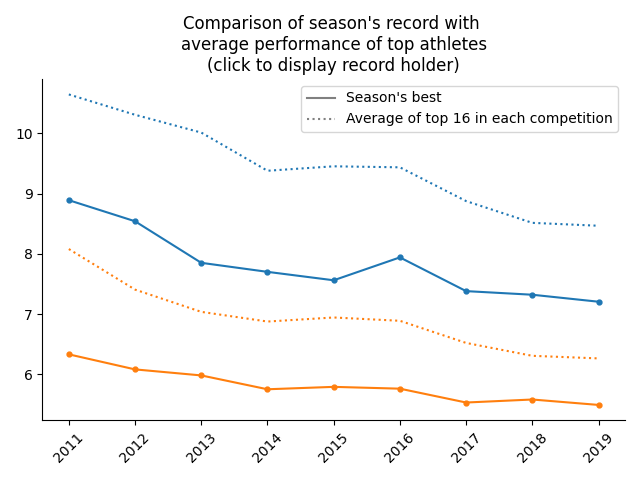

In [8]:
fig, ax = plt.subplots()

ax.set(title="Comparison of season's record with \naverage performance of top athletes\n(click to display record holder)")

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    
record_plot_w = df.loc[df['gender'] == 'women'].groupby(['year'])['time'].min().plot(
    label="Women", color='tab:blue', zorder=1, marker="o", markersize=3.5)  
mean_plot_w = df.loc[(df['gender'] == 'women') & (df['time'] <= 16) & (df['rank'] <= 16)].groupby(['year'])['time'].mean().plot(label="Mean, women", color='tab:blue', ls = ":")
annotations_w = []
for i in df.loc[df['gender'] == 'women'].groupby(['year'])['time'].idxmin():
    if df.iloc[i]['year'] != 2019:
        annotation = ax.annotate(df.iloc[i]['name'] + '\n' + str(df.iloc[i]['time']), (df.iloc[i]['year'], df.iloc[i]['time']), 
                                 bbox=dict(boxstyle="round,pad=.5", alpha=0.6), xytext=(-10, 10), textcoords='offset points', visible=False)
    else:
        annotation = ax.annotate(df.iloc[i]['name'] + '\n' + str(df.iloc[i]['time']), (df.iloc[i]['year'], df.iloc[i]['time']), 
                                 bbox=dict(boxstyle="round,pad=.5", alpha=0.6), xytext=(-90, -25), textcoords='offset points', visible=False)
    hidden_annotation = HiddenAnnotation(annotation)
    hidden_annotation.connect()
    annotations_w.append(hidden_annotation)


record_plot_m = df.loc[df['gender'] == 'men'].groupby(['year'])['time'].min().plot(label="Men", color='tab:orange', zorder=1, marker="o", markersize=3.5)
mean_plot_m = df.loc[(df['gender'] == 'men') & (df['time'] <= 12) & (df['rank'] <= 16)].groupby(['year'])['time'].mean().plot(label="Mean, men", color='tab:orange', ls = ":")
annotations_m = []
for i in df.loc[df['gender'] == 'men'].groupby(['year'])['time'].idxmin():
    if df.iloc[i]['year'] != 2019:
        annotation = ax.annotate(df.iloc[i]['name'] + '\n' + str(df.iloc[i]['time']), (df.iloc[i]['year'], df.iloc[i]['time']), 
                             bbox=dict(boxstyle="round,pad=.5", alpha=0.6, fc='tab:orange'), xytext=(-10, 10), textcoords='offset points', visible=False)
    else:
        annotation = ax.annotate(df.iloc[i]['name'] + '\n' + str(df.iloc[i]['time']), (df.iloc[i]['year'], df.iloc[i]['time']), 
                                 bbox=dict(boxstyle="round,pad=.5", alpha=0.6, fc='tab:orange'), xytext=(-60, 10), textcoords='offset points', visible=False)
    hidden_annotation = HiddenAnnotation(annotation)
    hidden_annotation.connect()
    annotations_m.append(hidden_annotation)



legend_elements = [Line2D([0], [0], color='grey', lw='1.5', label="Season's best"),
                   Line2D([0], [0], color='grey', lw='1.5', ls=":", label="Average of top 16 in each competition")]


ax.legend(handles=legend_elements)

ax.tick_params(axis='x', labelrotation=45)
ax.set(xlabel='')
fig.tight_layout()

## Comparison of the distribution of performances for each gender.
From my thorough and exclusively scientifically-motivated watching of speed climbing competitions, it appeared that men's performances are more homogenenenous and generally closer to the world record than women's. I plotted the distribution of performances by each gender to figure out whether it was the case. It was.

In [9]:
median_time_w = df.loc[df['gender'] == 'women']['time'].median()
median_time_m = df.loc[df['gender'] == 'men']['time'].median()

<IPython.core.display.Javascript object>


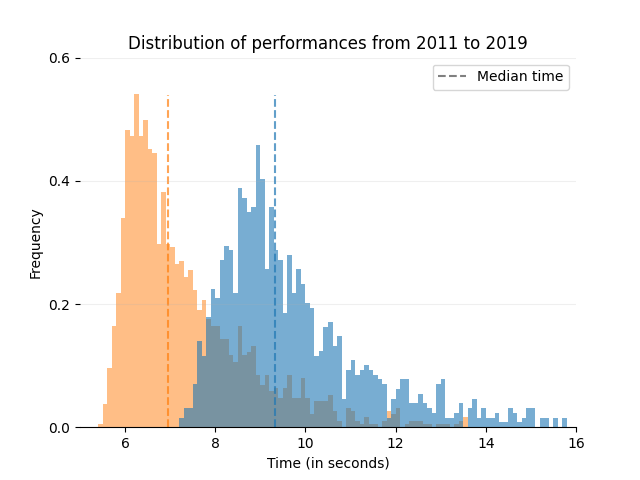

In [10]:
fig, ax = plt.subplots()

ax.set(ylim=(0,0.6), xlim=(5,16), yticks=np.arange(0,0.7, 0.2), xlabel='Time (in seconds)', ylabel='Frequency')
ax.grid(which='both', axis='y', alpha=0.2, zorder=0.1)
for spine in ['top', 'left', 'right']:
    ax.spines[spine].set_visible(False)        
        
women_hist = ax.hist(df.loc[df['gender'] == 'women']['time'], 
                      bins=np.arange(7,16, 0.1), color='tab:blue', density=True, alpha=0.6, zorder=1)
men_hist = ax.hist(df.loc[df['gender'] == 'men']['time'], histtype='barstacked', 
                    bins=np.arange(5,14, 0.1), color='tab:orange', density = True, alpha=0.5, zorder=0.5)

# plt.axvline(x=5.48, label="Reza Alipourshena, 04-30-17", color="tab:orange", lw=.7, ls="--")
plt.axvline(x=median_time_m, ymax=0.9, label="Median time, men", color="tab:orange", lw=1.5, ls="--", alpha=0.7, zorder=0.5)
# plt.axvline(x=6.99, label="Aries Susanti Rahayu, 10-19-19", color="tab:blue", lw=.7, ls="--")
plt.axvline(x=median_time_w, ymax=0.9, label="Median time, women", color="tab:blue", lw=1.5, ls="--", alpha=0.7)

ax.set(title="Distribution of performances from 2011 to 2019")
ax.legend(handles=[Line2D([0], [0], color='grey', lw='1.5', ls='--', label="Median time")]);

## Climbing fast or winning the competition
Does the fastest athlete always win? The following plot shows the relationship between rank and performance: athletes with faster times tend to place better (bottom left corner), and rank tends to increase as time increases (as shown by the main "branches" going up). Outliers (under the main branches) can be attributed to the knockout format of the finals, where absolute speed doesn't matter as much as beating your opponent; in particular, points closer to the bottom-right corner may denote a slip/foul from the runner-up.  

**A sufficient condition.** (dashed lines on the graph) For the men, climbing the wall in less than 6 seconds is enough to guarantee a place in the top 16. For the women, the threshold is at 8.4 (but less well-defined).

Note: Athletes going through the finals (last 16) will have two recorder times in one given competition (that is, two recorded times for one rank); additionnaly, the IFSC was somewhat inconsistent in reporting records for ranks 16 and above (depending on the particular competition, some are outright absent). In particular, this means that there are more records for ranks 16 and below than for others which can be seen on the plot, as the part of the graph below the y=16 line is much "fuller" than the rest.

In [11]:
sufficient_m = df.loc[(df['rank'] > 16) & (df['gender'] == 'men')]['time'].min()
sufficient_w = df.loc[(df['rank'] > 16) & (df['gender'] == 'women')]['time'].min()

<IPython.core.display.Javascript object>


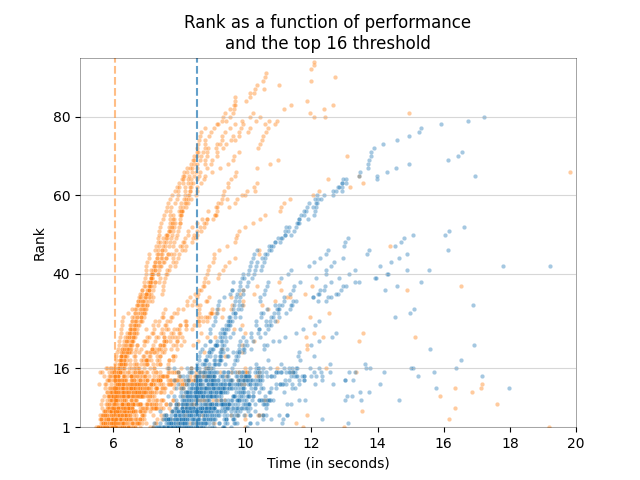

In [12]:
fig, ax = plt.subplots()

ax.set(title="Rank as a function of performance\nand the top 16 threshold", xlabel="Time (in seconds)", ylabel="Rank", ylim=(1,95), xlim=(5,20), yticks=[1, 16, 40, 60, 80])
ax.grid(alpha=0.5, axis='y')
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set(lw=0.5, alpha=0.5)

sns.scatterplot(x='time', y='rank', data=df.loc[(df['time'] < 20) & (df['gender'] == 'men')], s=10, color='tab:orange', alpha=0.4);
plt.axvline(x=sufficient_m, color="tab:orange", lw=1.5, ls="--", alpha=0.5)

sns.scatterplot(x='time', y='rank', data=df.loc[(df['time'] < 20) & (df['gender'] == 'women')], s=10, color='tab:blue', alpha=0.4);
plt.axvline(x=sufficient_w, color="tab:blue", lw=1.5, ls="--", alpha=0.7);


## Country ranking

<IPython.core.display.Javascript object>


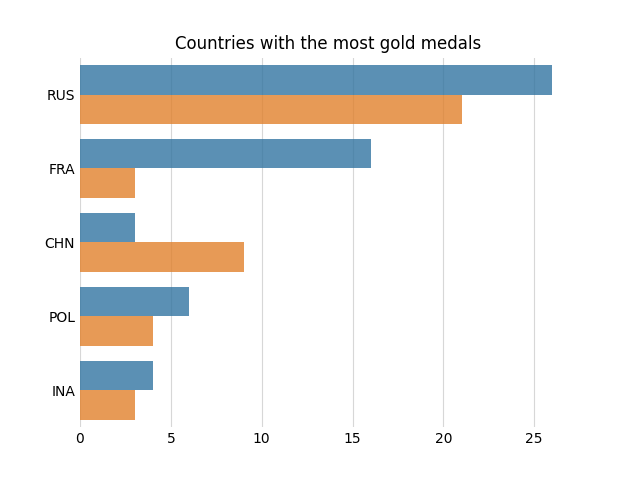

In [13]:
fig, ax1 = plt.subplots()

#sns.set_palette('tab10')

for spine in ['top', 'bottom', 'left', 'right']:
    ax1.spines[spine].set_visible(False)
    
sns.countplot(y="nation", data=df.loc[(df['rank'] == 1) & (df['round'] == 'final')], hue='gender',
              hue_order=['women', 'men'], alpha=0.8, order=['RUS', 'FRA', 'CHN', 'POL', 'INA'], zorder=2, ax=ax1);

ax1.set(title="Countries with the most gold medals", xlabel='', ylabel='')
ax1.grid(alpha=0.5, axis='x', zorder=0.1)
ax1.legend().set_visible(False)

plt.tick_params(length=0)